In [ ]:
# %pip install numpy tifffile matplotlib scipy scikit-image pyocclient

In [1]:
import numpy as np
from tifffile import imread
import matplotlib.pyplot as plt
from scipy.ndimage import median_filter, gaussian_filter1d

# Calcium Traces

Calcium traces show how fluorescence changes over time as calcium levels inside a neuron rise with activity. When a neuron fires, calcium enters the cell, increasing the fluorescence signal. These traces help identify when neurons are active, with peaks indicating periods of activity. Since the fluorescence can also include signals from surrounding tissue (neuropil), adjustments are made to focus on the activity of the neuron itself.


Run the below cell to get the data for today's session.

In [10]:
import owncloud
import os

if not os.path.exists('data'):
    print('Creating directory for data')
    os.mkdir('data')

if not os.path.exists('data/demoMovie.tif'):
    oc = owncloud.Client.from_public_link('https://uni-bonn.sciebo.de/s/NwtdrIg5wGdeGcB')
    oc.get_file('/', 'data/demoMovie.tif');

---

## Fluorescence Signals from a Single Pixel.

In this section, let us look at the brightness (fluorescence) of a single pixel over time. This brightness changes when calcium levels in the cell change which is an indicator that the neuron is "active". Plotting how the fluorescence changes shows us when "activity" might have happened in that pixel. 

| **Code**                                 | **Description**                                                                |
| :--------------------------------------- | :----------------------------------------------------------------------------- |
| `data = imread('data/demoMovie.tif')`    | Load the calcium imaging data from a `.tif` file.                              |
| `data[0, :, :]`              | Select the first frame from the data.                                          |
| `data[-1, :, :]`             | Select the last frame from the data.                                           |
| `data.mean(axis=0)` | Calculate the mean image over all frames.                                      |
| `data.max(axis=0)`           | Compute the maximum intensity projection over all frames.                      |
| `data[100:500, :, :]`        | Select frames from index 100 to 500.                                           |
| `data[:, 20:35, 15:35]`      | Crop a specific region of the image.                                           |
| `plt.scatter(60, 30, color='r')`         | Plot a red marker at pixel location (60, 30) on the image.                     |
| `trace = data[:, 25, 21]`                | Extract the fluorescence trace from a specific pixel (25, 21) over all frames. |

*How do I look for individual frames in my data to search for neurons?*

**Example** Plot the first frame as representative image.

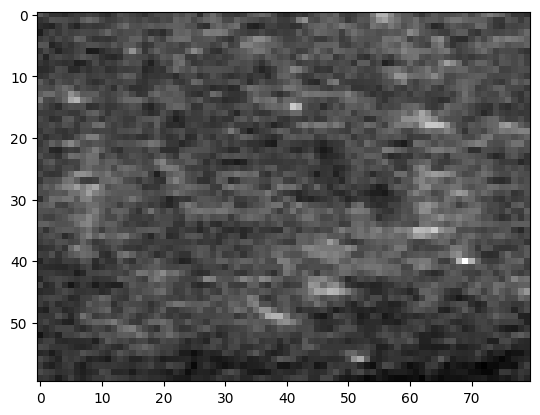

In [11]:
data = imread('data/demoMovie.tif')
rep_image = data[0, :, :]
plt.imshow(rep_image, cmap='gray')

Plot the 116th frame as representative image.

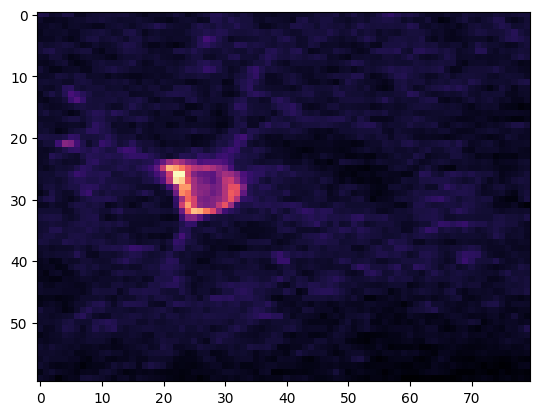

In [12]:
plt.imshow(data[116], cmap='magma');

Plot the last frame as representative image.

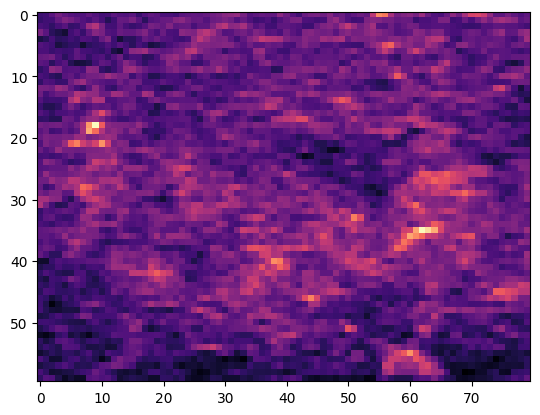

In [13]:
plt.imshow(data[-1], cmap='magma');

*How do I see as many active neurons as possible in one image?*

**Example** Plot mean projection of all the frames as representative image.

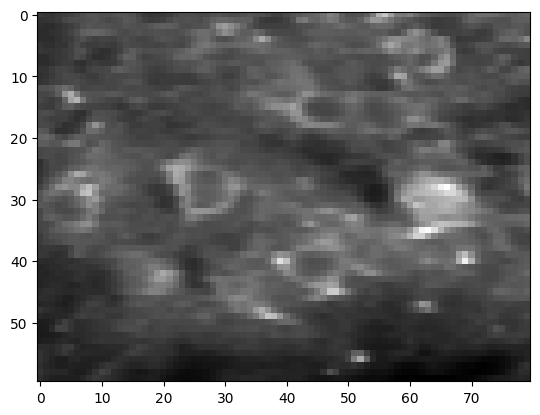

In [15]:
data = imread('data/demoMovie.tif')
rep_image = data.mean(axis=0)
plt.imshow(rep_image, cmap='gray')

Plot the maximum projection of all frames as representative image.

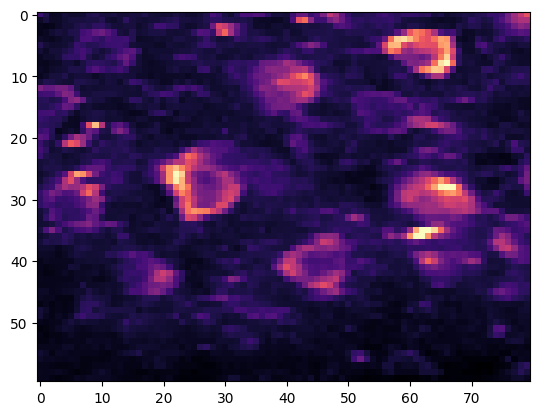

In [21]:
plt.imshow(data.max(axis=0), cmap='magma');

Plot maximum projection from 100th to 500th frame only.

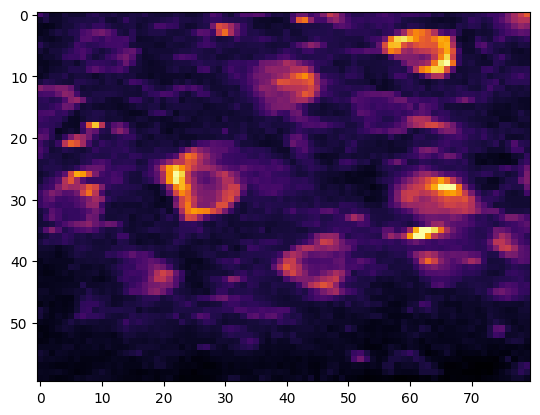

In [27]:
plt.imshow(data[99:].max(axis=0), cmap='inferno');

*How do I zoom into the cell I am interested in?*

Let us consider three cells located within rectangular box defined by:

| **Cell**   | **xmin** | **xmax** | **ymin** | **ymax** |
| :--------- | :------- | :------- | :------- | :------- |
| **Cell 1** | 15       | 35       | 20       | 35       |
| **Cell 2** | 55       | 75       | 23       | 40       |
| **Cell 3** | 0        | 10       | 23       | 40       |

**Example** Plot mean projection image cropped to Cell 1.

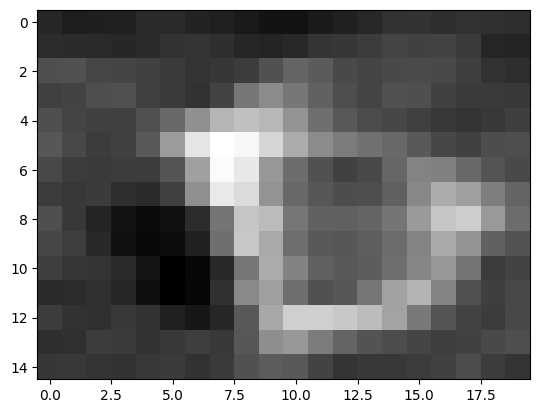

In [28]:
data = imread('data/demoMovie.tif')
rep_image = data[:, 20:35, 15:35].mean(axis=0)
plt.imshow(rep_image, cmap='gray')

Plot mean projection image cropped to Cell 2.

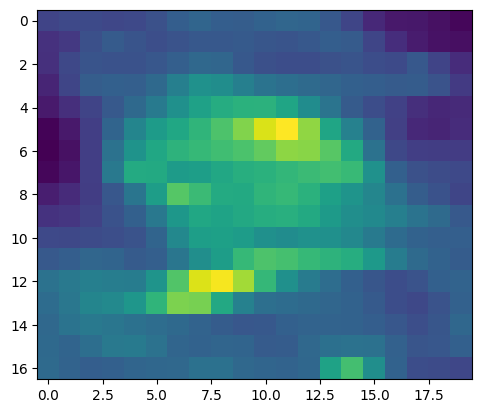

In [34]:
plt.imshow(data[:, 23:40, 55:75].mean(axis=0));

Plot max projection of only the first 100 frames cropped to Cell 3.

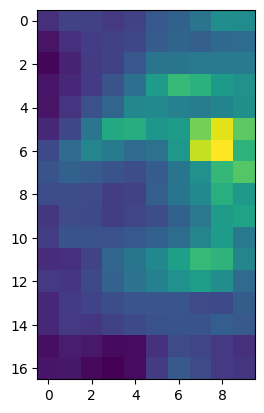

In [35]:
plt.imshow(data[:100, 23:40, 0:10].mean(axis=0));

*How do I select a pixel from the neuron that I am interested in?*

For these exercises, let us consider pixels on three cells located at:

| **Cell**   | **Width (x-coordinate)** | **Height (y-coordinate)** |
| :--------- | :----------------------- | :------------------------ |
| **Cell 1** | 60                       | 30                        |
| **Cell 2** | 39                       | 40                        |
| **Cell 3** | 21                       | 25                        |


**Example** Select a pixel from Cell 1.

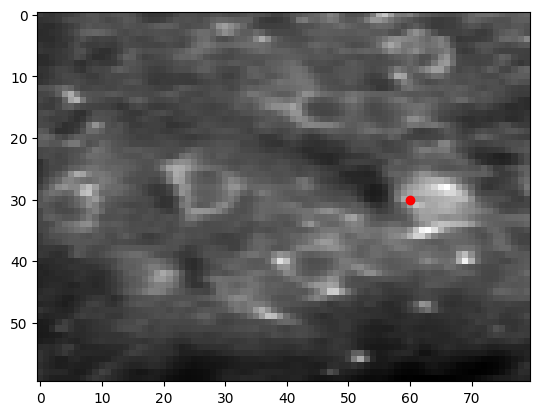

In [38]:
rep_image = data.mean(axis=0)
plt.imshow(rep_image, cmap='gray')
plt.scatter(60, 30, color='r')

Select a pixel from Cell 2.

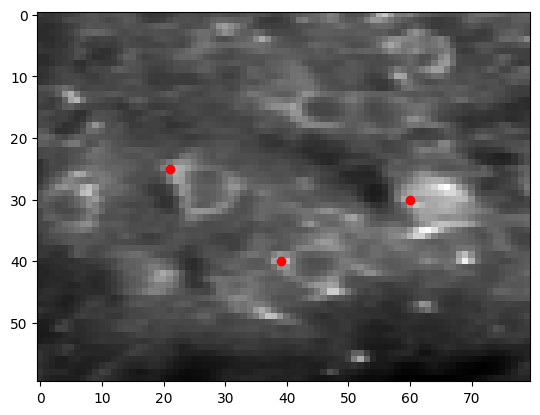

In [39]:
rep_image = data.mean(axis=0)
plt.imshow(rep_image, cmap='gray')
plt.scatter([60, 39, 21], [30, 40, 25], color='r');

Select a pixel from Cell 3.

*What does the activity of my neuron look like?*

**Example** Plot calcium trace extracted from Cell 3.

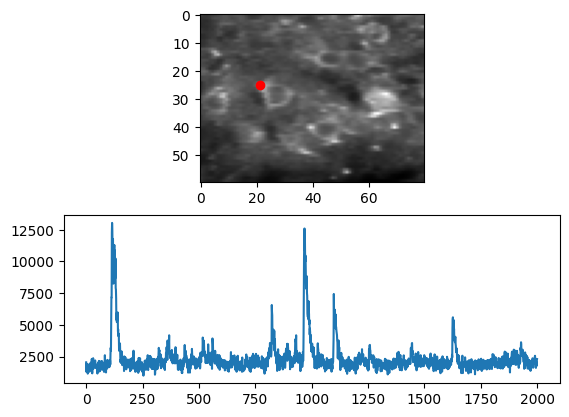

In [40]:
rep_image = data[:, :, :].mean(axis=0)
trace = data[:, 25, 21]

plt.subplot(211)
plt.imshow(rep_image, cmap='gray')
plt.scatter(21, 25, color='r')

plt.subplot(212)
plt.plot(trace)

Plot calcium trace extracted from Cell 2.

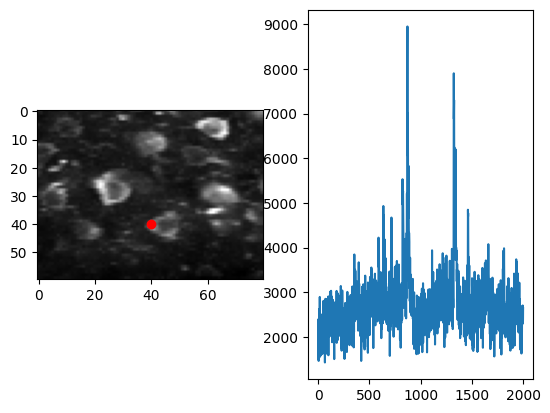

In [54]:
x, y = 40, 40

plt.subplot(1, 2, 1);
plt.imshow(data.max(axis=0), cmap='gray');
plt.scatter(x, y, color='r');

plt.subplot(1, 2, 2);
plt.plot(data[:, y, x]);

Plot calcium trace extracted from Cell 1.

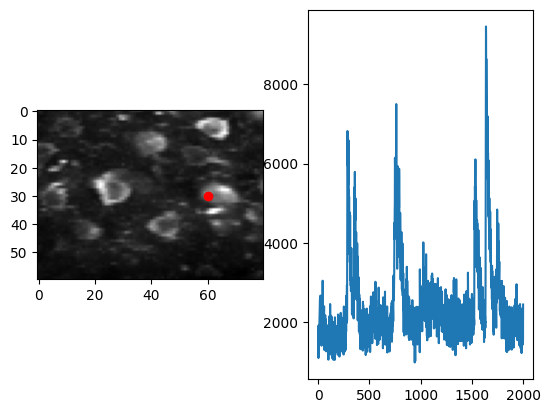

In [55]:
x, y = 60, 30

plt.subplot(1, 2, 1);
plt.imshow(data.max(axis=0), cmap='gray');
plt.scatter(x, y, color='r');

plt.subplot(1, 2, 2);
plt.plot(data[:, y, x]);

## Neuropil Correction.

The brightness we see in a pixel is, usually, not just from the cell we care about. It also includes light from nearby tissue called neuropil. To get a cleaner signal, we subtract a portion of this surrounding signal. This process is called neuropil correction.

| **Code**                      | **Description**                                                       |
| :---------------------------- | :-------------------------------------------------------------------- |
| `np.mean(data, axis=(1,2))`   | Compute the mean fluorescence for each frame across all pixels.       |
| `np.median(data, axis=(1,2))` | Compute the median fluorescence for each frame across all pixels.     |
| `np.min(data, axis=(1,2))`    | Compute the minimum fluorescence for each frame across all pixels.    |
| `data[:, 40, 39]`             | Extract the fluorescence trace from pixel (40, 39) across all frames. |

In [56]:
data = imread('data/demoMovie.tif')
rep_image = np.mean(data, axis=0)

*How do I get neuropil trace for correction and it's okay if it also contains some signal from neurons?*

**Example** Take global mean of all frames and pixels to get neuropil trace.

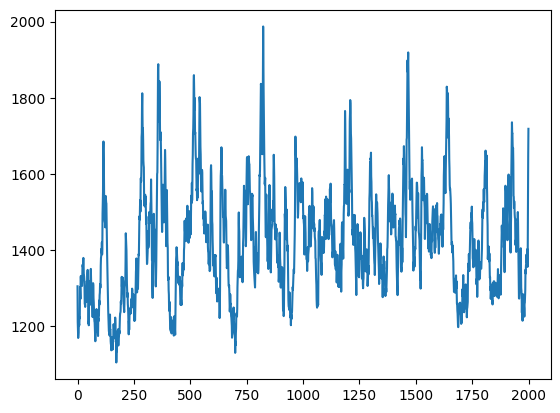

In [58]:
npil_trace = np.mean(data, axis=(1,2))
plt.plot(npil_trace);

Take global median of all frames and pixels to get neuropil trace.

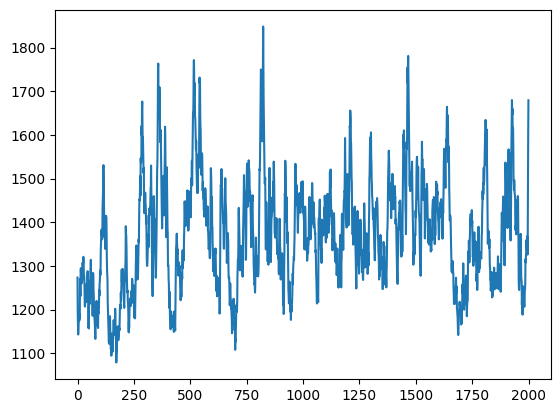

In [59]:
npil_trace = np.median(data, axis=(1,2))
plt.plot(npil_trace);

Take global minimum of all frames and pixels to get neuropil trace.

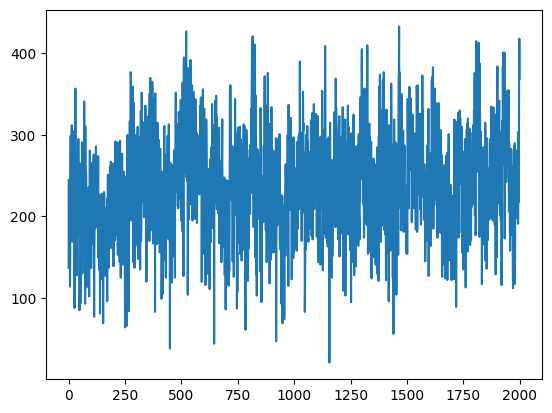

In [61]:
npil_trace = np.min(data, axis=(1,2))
plt.plot(npil_trace);

*How do I get neuropil trace from just outside my neuron?*

| **Cell**   | **Pixel (x, y)** | **Neuropil Pixel (x, y)** |
| :--------- | :--------------- | :------------------------ |
| **Cell 1** | (60, 30)         | (56, 33)                  |
| **Cell 2** | (39, 40)         | (39, 45)                  |
| **Cell 3** | (21, 25)         | (20, 28)                  |


**Example** Extract neuropil trace from just outside Cell 2.

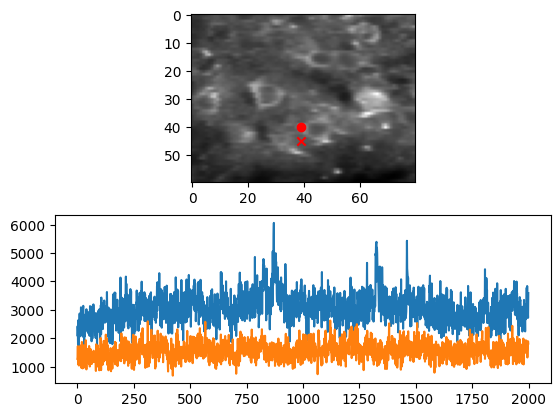

In [62]:
plt.subplot(211)
plt.imshow(rep_image, cmap='gray')
plt.scatter(39, 40, color='r')
plt.scatter(39, 45, color='r', marker='x')

plt.subplot(212)
plt.plot(data[:, 40, 39])
plt.plot(data[:, 45, 39])

Extract neuropil trace from just outside Cell 1.

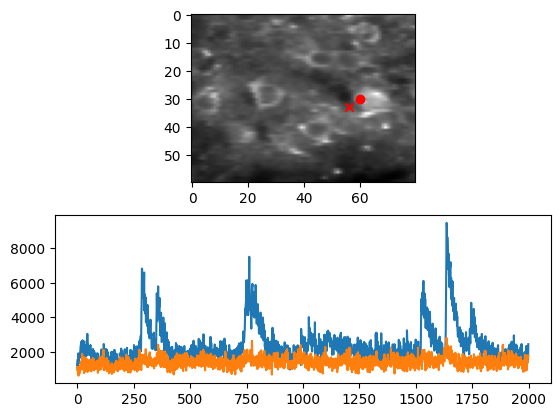

In [65]:
plt.subplot(211)
plt.imshow(rep_image, cmap='gray')
plt.scatter(60, 30, color='r')
plt.scatter(56, 33, color='r', marker='x')

plt.subplot(212)
plt.plot(data[:, 30, 60])
plt.plot(data[:, 33, 56]);

Extract neuropil trace from just outside Cell 3.

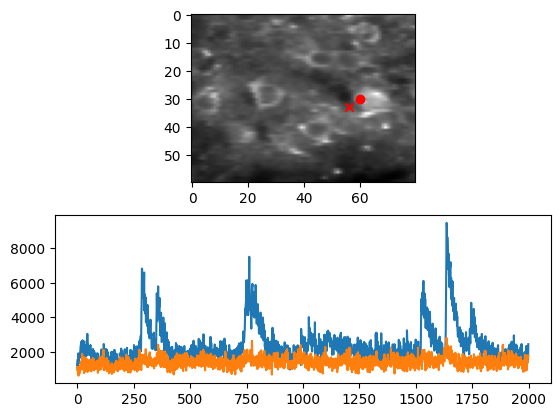

In [66]:
plt.subplot(211)
plt.imshow(rep_image, cmap='gray')
plt.scatter(60, 30, color='r')
plt.scatter(56, 33, color='r', marker='x')

plt.subplot(212)
plt.plot(data[:, 30, 60])
plt.plot(data[:, 33, 56]);

*How should I do neuropil subtraction?*

**Example** Subtract neuropil trace from Cell 3 calcium trace with a scaling factor of 1.0.

In [ ]:
cell_trace = data[:, 25, 21]
neuropil_trace = data[:, 28, 20]
r = 1.0
F_corr = cell_trace - r*neuropil_trace

plt.subplot(211)
plt.plot(cell_trace)
plt.plot(neuropil_trace)

plt.subplot(212)
plt.plot(F_corr)

Subtract neuropil trace from Cell 2 calcium trace with a scaling factor of 0.7.

Subtract neuropil trace from Cell 1 calcium trace with a scaling factor of 1.0.

## Estimating Baseline Fluorescence (F0).

Even when a neuron is not active, the signal is not zero because of slow change in signal or noise. This resting level of fluorescence is called **baseline flurorescence** or **F0**. 

| **Code**                     | **Description**                                               |
| :--------------------------- | :------------------------------------------------------------ |
| `plt.axhline(F0, color='r')` | Plot a horizontal line in red at the single baseline value F0.     |
| `np.mean(trace)`             | Compute the mean fluorescence value of the trace.             |
| `np.percentile(trace, 10)`   | Compute the 10th percentile value of the fluorescence trace.  |
| `median_filter(trace, 501)`  | Apply a median filter with a window size of 501 to the trace. |
| `plt.plot(F0)`  | Plot 1-Dimensional F0 value. |

In [73]:
cell1_corr_trace = data[:, 40, 39] - 0.7 * data[:, 45, 39]
cell2_corr_trace = data[:, 30, 60] - 0.7 * data[:, 33, 56]
cell3_corr_trace = data[:, 25, 21] - 0.7 * data[:, 28, 20]

*How do I get baseline activity of my cell and it's okay if I don't consider local variations?*

**Example** Plot mean baseline activity of Cell 1.

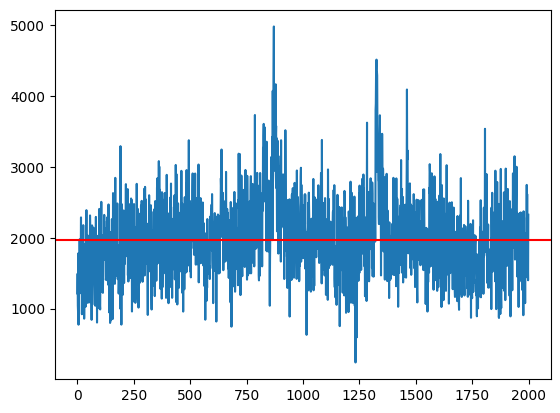

In [71]:
F0 = np.mean(cell1_corr_trace)
plt.plot(cell1_corr_trace)
plt.axhline(F0, color='r')

Plot median baseline activity of Cell 2.

Plot 10th percentile as baseline activity of Cell 3.

*How do I consider local variations to estimate baseline activity of my cell?*

**Example** Use moving median window to estimate baseline activity of Cell 1 with window size of 501.

In [ ]:
F0 = median_filter(cell1_corr_trace, 501)
plt.plot(cell1_corr_trace)
plt.plot(F0, color='r')

Use moving median window to estimate baseline activity of Cell 2 with window size of 501.

Use moving median window to estimate baseline activity of Cell 1 with an even larger window size.

Use moving median window to estimate baseline activity of Cell 1 with a very small window size.

## dF/F0 Normalization.

We usually want to quantify how much the fluorescence signal increases relative to that baseline so that we can compare signals from different neurons. This is done by computing **ΔF/F₀**, where:

$\Delta F/F_0 = \frac{F - F_0}{F_0}$


Here, **F** is the fluorescence at each time point, and **ΔF** (delta F) is the difference between the current signal and the baseline. The resulting ΔF/F₀ value expresses the signal change as a **fraction of the baseline**, which is useful for comparing activity levels across different cells or imaging sessions.


| **Code**                  | **Description**                                                                   |
| :------------------------ | :-------------------------------------------------------------------------------- |
| `F0 = np.median(trace)`   | Compute the baseline value (F0) of the trace using the median.                    |
| `df = trace - F0`         | Subtract the baseline (F0) from the trace to get the change in fluorescence (ΔF). |
| `plt.plot(trace)`         | Plot the trace.                                             |
| `dff = (trace - F0) / F0` | Normalize the fluorescence change (ΔF) by the baseline (F0) to compute ΔF/F₀.     |

*How do I remove baseline activity from my cell's activity?*

**Example** Remove median baseline activity from Cell 1.

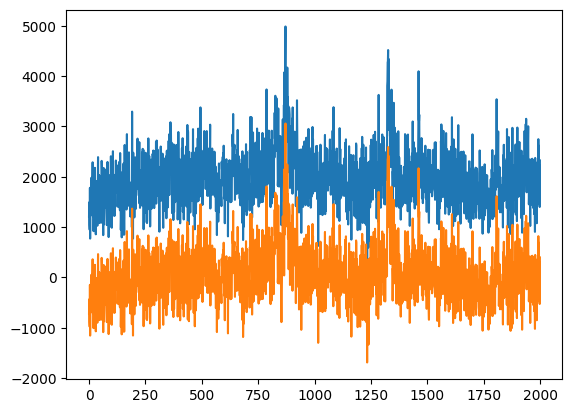

In [72]:
F0 = np.median(cell1_corr_trace)
df = cell1_corr_trace - F0

plt.plot(cell1_corr_trace)
plt.plot(df)

Remove baseline estimated from moving median filter with an appropriate size from the activity from Cell 3.

Remove baseline estimated from moving median filter with a very small size from the activity from Cell 3.

*Finally, how do I get my baseline normalized calcium traces?*

**Example** Plot df/f0 for Cell 1.

In [ ]:
F0 = median_filter(cell1_corr_trace, 201)
dff = (cell1_corr_trace - F0) / F0
plt.plot(dff)

Plot df/f0 for Cell 2.

Plot df/f0 for Cell 3.